# Applied Machine Learning Homework 4 Question 1 



## Q1) From Huggingface (https://huggingface.co/Links to an external site.) select and download a pre-trained CLIP model (you can use your own computer, Colab, Kaggle... to store the model). Describe the model you downloaded - what is its architecture (e.g. CNN/ViT), number of layers, parameters per layer - breakdown the parameters and explain what they are doing (e.g. are they parts of K, Q and V matrices, bias, feature maps, dense layer...).

## CLIP (Contrastive Language-Image Pre-training)

Source: openai/clip-vit-base-patch32

### 1. Architecture

- **Image Encoder**:
    - **ResNet**:
    Includes variants like ResNet-50, ResNet-101, and scaled versions (e.g., RN50x64).
    Features ResNet-D enhancements, antialiased pooling, and attention pooling.
    - **Vision Transformer (ViT)**: The model uses a Vision Transformer as its backbone for processing images. Uses variants such as ViT-B/32 (86M parameters) and ViT-L/14 (307M parameters).

- **Text Encoder**: 
    - The text encoder is based on the GPT-2 architecture.
    - The input text is tokenized and embedded into vectors using a learned embedding layer.
    - Positional Encoding: Like the ViT, positional encodings are added to the token embeddings to retain the sequence information.


- **Shared Embedding Space**:
    - **Projection Layers**: 
    After the vision and text encoders process their respective inputs, the resulting embeddings are projected into a shared space using separate linear projection layers for images and text.
    - **Contrastive Learning**: 
    During training, CLIP uses a contrastive loss to align the image and text embeddings in this shared space. Matching pairs (image and its corresponding caption) are brought closer together, while non-matching pairs are pushed apart.

### 2. Number of Layers and Parameters

- **Vision Transformer (ViT)**: 
    - The Vision Transformer used in CLIP has 12 layers with 512 hidden units and 8 attention heads.
    - Typical parameter count: ~23M for ResNet-50.
- **Text Encoder (GPT-2)**: 
    - The text encoder used in CLIP has 24 layers.
    - Typical parameter count: ~63M.

### Parameters Breakdown

- **Embedding Layer**: Converts input images/text into embeddings.
- **Transformer Layers**: Each layer consists of multi-head self-attention mechanisms and feed-forward neural networks.
- **Parameters**: The parameters include weights for the attention mechanism, feed-forward networks, and normalization layers.
- **K, Q, V Matrices**: These are part of the self-attention mechanism, where K (Key), Q (Query), and V (Value) matrices are used to compute attention scores.

### 3. Functionality

- **Image and Text Embeddings**: The model learns to map images and text into a shared embedding space.
- **Contrastive Loss**: The model is trained using a contrastive loss function, which encourages the embeddings of matching image-text pairs to be closer together, while non-matching pairs are pushed apart.
- **Zero-Shot Transfer**: After pre-training, the model can perform tasks without additional training by leveraging natural language descriptions.

### 4. Training and Objectives
- The model is trained on a dataset of 400M image-text pairs using a contrastive loss to maximize similarity between correct pairs and minimize similarity for incorrect ones.
- Zero-shot transfer is achieved by encoding class names or descriptions as text embeddings and comparing them to image embeddings.


## Q2 a)The dataset contains images from the following eight categories: airplane, car, chair, cup, dog, donkey, duck and hat. Each category contains images in five different conditions: realistic, geons, silhouettes, blured and features. Evaluate the model for each condition separately. For each image in the dataset, feed the image into the model together with a text label of a particular category (for each image, evaluate labels of all eight categories). If the model outputs highest correlation for the correct label, consider that as correct classification and otherwise as incorrect classification. Quantify model accuracy for each of the five conditions.

In [3]:
import os
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

data_dir = "./dataset"  
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions = ["blurred", "features", "geons", "realistic", "silhouettes"]

In [5]:
def count_images_per_category(data_dir, categories, conditions):
    category_counts = {condition: {category: 0 for category in categories} for condition in conditions}

    for condition in conditions:
        condition_dir = os.path.join(data_dir, condition)

        for category in categories:
            category_images = [f for f in os.listdir(condition_dir) if f.lower().startswith(category)]
            category_counts[condition][category] = len(category_images)

    return category_counts


image_counts = count_images_per_category(data_dir, categories, conditions)

print("Number of images per category:")
for condition, counts in image_counts.items():
    print(f"Condition: {condition}")
    for category, count in counts.items():
        print(f"  {category}: {count}")

Number of images per category:
Condition: blurred
  airplane: 6
  car: 5
  chair: 6
  cup: 5
  dog: 5
  donkey: 4
  duck: 6
  hat: 5
Condition: features
  airplane: 6
  car: 5
  chair: 5
  cup: 5
  dog: 5
  donkey: 4
  duck: 6
  hat: 5
Condition: geons
  airplane: 8
  car: 8
  chair: 7
  cup: 8
  dog: 7
  donkey: 7
  duck: 7
  hat: 7
Condition: realistic
  airplane: 5
  car: 5
  chair: 5
  cup: 5
  dog: 6
  donkey: 5
  duck: 5
  hat: 5
Condition: silhouettes
  airplane: 5
  car: 5
  chair: 5
  cup: 6
  dog: 4
  donkey: 5
  duck: 5
  hat: 5


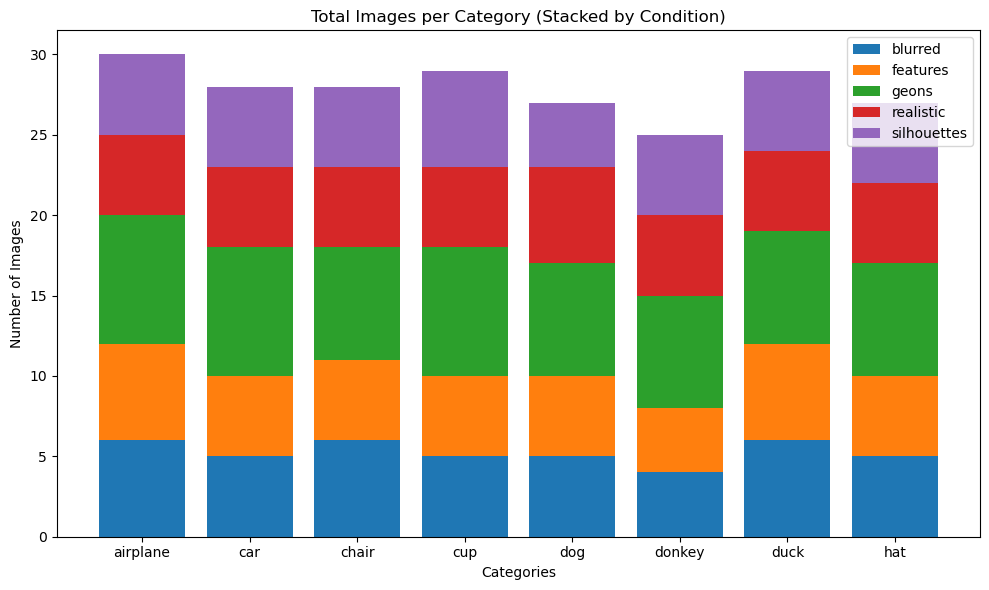

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

category_totals = np.zeros(len(categories))
for condition in conditions:
    counts = [image_counts[condition][cat] for cat in categories]
    ax.bar(categories, counts, bottom=category_totals, label=condition)
    category_totals += np.array(counts)

ax.set_xlabel('Categories')
ax.set_ylabel('Number of Images')
ax.set_title('Total Images per Category (Stacked by Condition)')
ax.legend()

plt.tight_layout()
plt.show()


In [7]:
def evaluate_model(data_dir, categories, conditions):
    accuracy = {condition: 0 for condition in conditions}

    for condition in conditions:
        correct = 0
        total = 0
        condition_dir = os.path.join(data_dir, condition)

        for category in categories:
            category_images = [f for f in os.listdir(condition_dir) if f.lower().startswith(category)]

            for img_name in tqdm(category_images, desc=f"Evaluating {condition}/{category}"):
                img_path = os.path.join(condition_dir, img_name)
                image = Image.open(img_path).convert("RGB")

                inputs = processor(text=categories, images=image, return_tensors="pt", padding=True)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                outputs = model(**inputs)

                logits_per_image = outputs.logits_per_image
                probs = logits_per_image.softmax(dim=-1)

                pred = torch.argmax(probs).item()
                if categories[pred] == category:
                    correct += 1
                total += 1

        if total > 0:
            accuracy[condition] = correct / total
        else:
            accuracy[condition] = 0

    return accuracy
accuracy = evaluate_model(data_dir, categories, conditions)

for condition, acc in accuracy.items():
    print(f"Accuracy for {condition}: {acc * 100:.2f}%")


Evaluating silhouettes/hat: 100%|████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]

Accuracy for blurred: 69.05%
Accuracy for features: 80.49%
Accuracy for geons: 54.24%
Accuracy for realistic: 100.00%
Accuracy for silhouettes: 92.50%


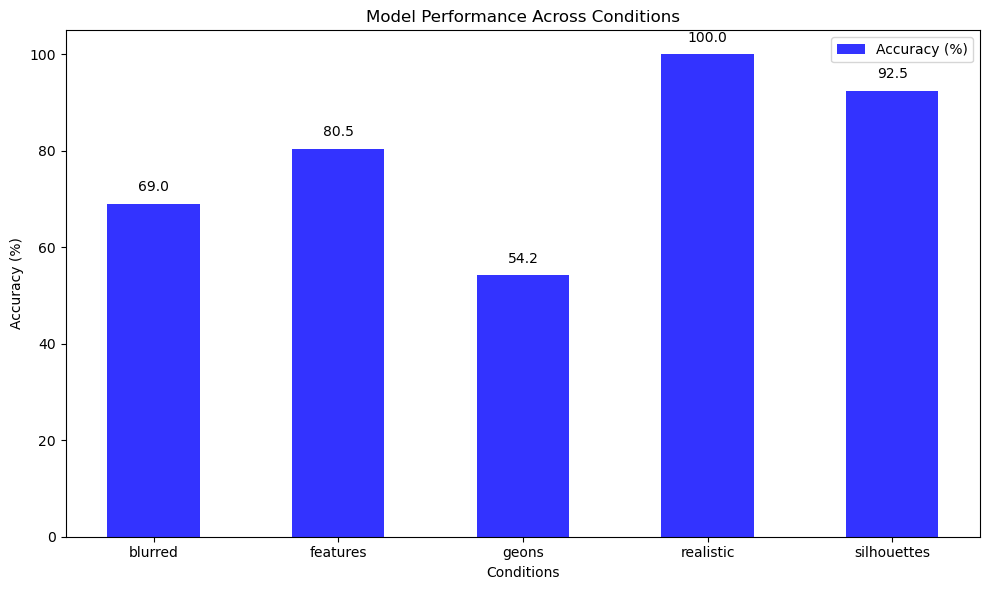

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

conditions = list(accuracy.keys())
accuracies = [acc * 100 for acc in accuracy.values()]

bar_width = 0.5
x = np.arange(len(conditions))

bars = ax.bar(x, accuracies, bar_width, label='Accuracy (%)', color='blue', alpha=0.8)

ax.set_xlabel('Conditions')
ax.set_title('Model Performance Across Conditions')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.set_ylabel('Accuracy (%)')
ax.legend()

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.1f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## b)In which conditions is your models better/worse/similar to babies (Fig. 3A in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site.)?

# Comparison of Model and Babies' Performance Across Conditions

## 1. Blurred
The model achieved an accuracy of 69.05%. Babies perform moderately in this condition as they rely on the overall shape and structure for object recognition. The model performs reasonably well, demonstrating robustness to blurring effects, which aligns with the moderate performance observed in infants. The performance is similar to that of infants.

## 2. Features
The model achieved an accuracy of 80.49%. Babies' performance in this condition is low, as they often require holistic visual context and struggle with isolated features. The model significantly outperforms infants. This result is expected since models like CLIP are trained to leverage isolated discriminative features for classification. The model performs better than infants.

## 3. Geons
The model achieved an accuracy of 54.24%. Babies' performance in this condition is low to moderate, as geons are abstract representations and can be challenging without prior experience. The model shows moderate performance but likely outperforms infants, who find abstract representations more difficult. The model performs better than infants, though not as robustly as in other conditions.

## 4. Realistic
The model achieved an accuracy of 100.00%. Babies perform highly in this condition, as realistic images closely resemble the natural stimuli they encounter in their environment. The model achieves perfect accuracy, reflecting its ability to generalize well with naturalistic images. Infants are also highly adept in this condition, so the performance is similar or slightly better compared to infants.

## 5. Silhouettes
The model achieved an accuracy of 92.50%. Babies perform moderately in this condition, as they may rely on edge-based recognition but often require additional details. The model excels with silhouettes, leveraging edge-based and outline information to outperform infants, who struggle more with such limited cues. The model performs better than infants.


## Q3)From the output of the final layer of the vision encoder (before the projection layer into the shared embedding space) take embeddings for each image in the dataset. Apply t-SNE to those embeddings and plot them in a 2D space - plot little images of objects in the embedding space (something like Fig. 4 in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site. but no need for color coding of bounding boxes)

In [10]:
def extract_embeddings_and_labels(data_dir, categories, conditions):
    embeddings = []
    image_paths = []
    labels = []

    for condition in conditions:
        condition_dir = os.path.join(data_dir, condition)

        for category in categories:
            category_images = [f for f in os.listdir(condition_dir) if f.lower().startswith(category)]

            for img_name in tqdm(category_images, desc=f"Extracting Embeddings {condition}/{category}"):
                img_path = os.path.join(condition_dir, img_name)
                image = Image.open(img_path).convert("RGB")

                inputs = processor(images=image, return_tensors="pt").to(device)
                
                vision_outputs = model.vision_model(pixel_values=inputs['pixel_values'])
                embedding = vision_outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().detach().numpy()

                embeddings.append(embedding)
                image_paths.append(img_path)
                labels.append(category)

    return np.array(embeddings), image_paths, labels

def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

embeddings, image_paths, labels = extract_embeddings_and_labels(data_dir, categories, conditions)

Extracting Embeddings silhouettes/hat: 100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


Adding images to plot: 100%|███████████████████████████████████████████████████████| 223/223 [00:00<00:00, 2232.08it/s]


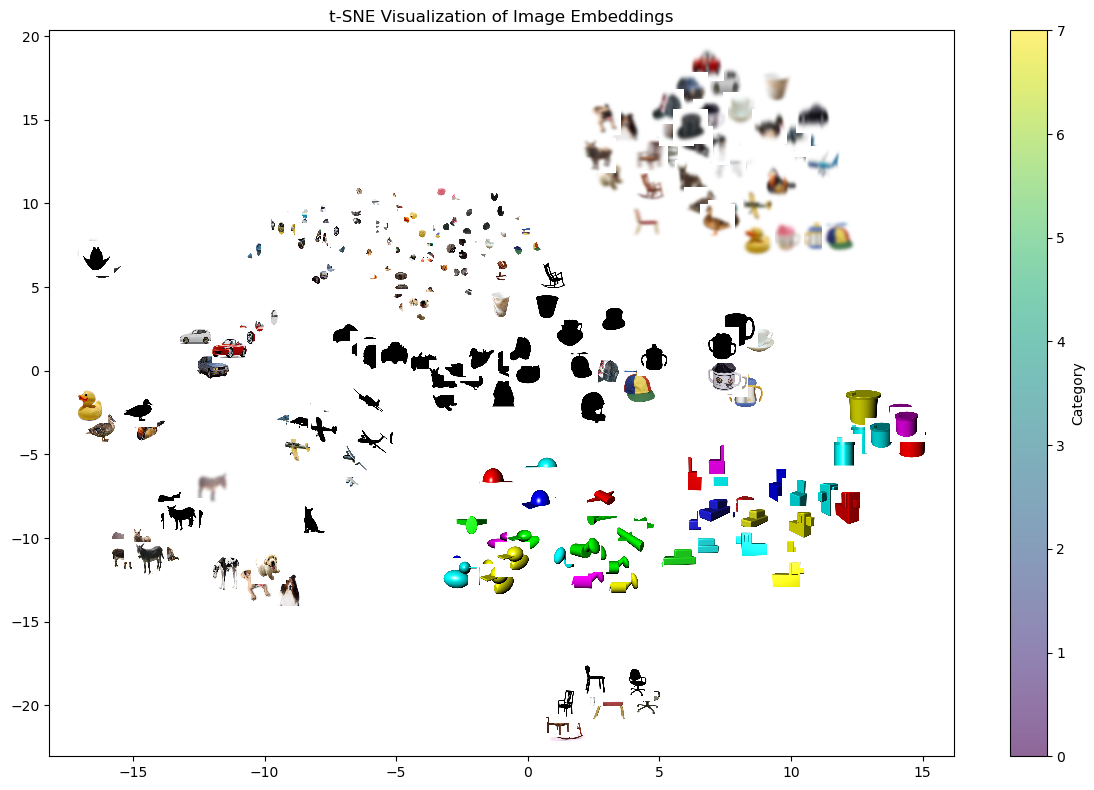

In [11]:
def plot_tsne_with_images(X, images, labels=None, min_distance=0.04, figsize=(12, 8), image_zoom=0.1):
    
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(X)

    if labels is not None and isinstance(labels[0], str):
        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(labels)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("t-SNE Visualization of Image Embeddings")

    if labels is not None:
        scatter = ax.scatter(
            reduced_data[:, 0], 
            reduced_data[:, 1], 
            c=labels, 
            alpha=0.6, 
            cmap=plt.cm.viridis
        )
        plt.colorbar(scatter, ax=ax, label="Category")

    resized_images = [img.resize((250,250)) for img in images]  

    neighbors = np.array([[10., 10.]])  
    for index, image_coord in enumerate(tqdm(reduced_data, desc="Adding images to plot")):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]

            if resized_images is not None:
                image = resized_images[index]
                imagebox = AnnotationBbox(OffsetImage(image, zoom=image_zoom), image_coord, frameon=False)
                ax.add_artist(imagebox)

    plt.tight_layout()
    plt.show()


embeddings = np.array(embeddings)
image_list = [Image.open(path).convert("RGB") for path in image_paths]
labels = [label for label in labels]

plot_tsne_with_images(X=embeddings, images=image_list, labels=labels, image_zoom=0.1)


# Observations from the t-SNE Plot

### Cluster Formation
Images group by category (e.g., airplanes, dogs, cups), showing the model's ability to capture semantic similarities.

### Condition-Specific Groups
Silhouettes cluster distinctly, while realistic and feature-based images are more dispersed but aligned within categories.

### Inter-Class Separation
Most categories (e.g., airplanes, ducks) are well-separated, but visually similar objects like chairs and cups show slight overlap.

### Cluster Density
Categories like cups and hats have dense clusters, while donkeys and dogs are more dispersed.

### Silhouettes and Geons
Silhouette images form clear clusters, reflecting the model's reliance on edge-based features.

### Summary
The model effectively groups images by category and condition but shows slight overlap for visually similar objects.
